<a href="https://colab.research.google.com/github/harvard-ml-courses/a-cs281-demo/blob/master/20_UGMTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -qU plotly torch daft opt-einsum networkx
!rm -fr start; git clone --single-branch -b demos2018 -q https://github.com/harvard-ml-courses/cs281-demos start; cp -f start/cs281.py cs281.py

In [0]:
import opt_einsum as oe

In [0]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
G = nx.Graph()

## Training Undirected Graphical Models


In [0]:
psi = {}
sizes = {"a": 10, 
         "b": 5, 
         "c": 20,
         "d": 30,
         "e": 40}



In [0]:
# Unary potentials
G.add_node("a")
psi["a"] = torch.rand(sizes["a"])

G.add_node("b")
psi["b"] = torch.rand(sizes["b"])


G.add_node("c")
psi["c"] = torch.rand(sizes["c"])

G.add_node("d")
psi["d"] = torch.rand(sizes["d"])


G.add_node("e")
psi["e"] = torch.rand(sizes["e"])


In [0]:
# Clique potentials
G.add_edge("a", "b")
G.add_edge("a", "c")
G.add_edge("c", "b")
psi["abc"] = torch.rand(sizes["a"], sizes["b"], sizes["c"])


G.add_edge("c", "d")
psi["cd"] = torch.rand(sizes["c"], sizes["d"])


G.add_edge("c", "e")
psi["ce"] = torch.rand(sizes["c"], sizes["e"])


In [0]:

# New -> Train psi functions
for clique in psi:
    psi[clique] = torch.tensor(psi[clique], requires_grad = True)

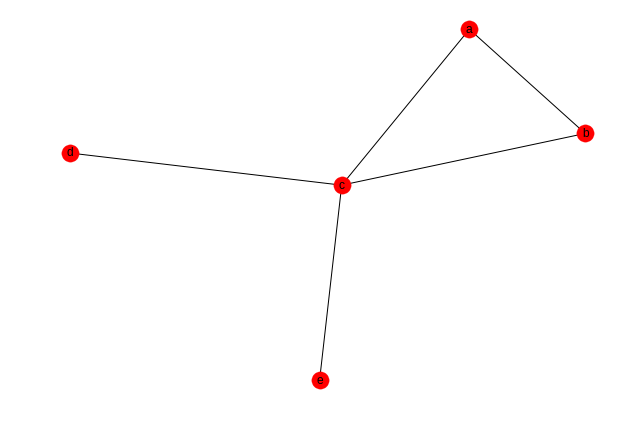

In [0]:
nx.draw(G, with_labels=True)

In [0]:
# Compute the normalization term
Z = torch.einsum("a,b,c,d,e,abc,cd,ce->", 
             [psi["a"], psi["b"], psi["c"], psi["d"], psi["e"], psi["abc"], psi["cd"], psi["ce"]])
Z

tensor(1898.1833, grad_fn=<AsStridedBackward>)

In [0]:

def prob_assignment(K, Z):
    score = 1
    for clique in psi:
        score *= psi[clique][tuple(K[var] for var in clique)]
    return score / Z
K = {"a" : 1, "b" : 2, "c" : 5, "d" : 4, "e" : 3}

In [0]:
prob_assignment(K, Z)

tensor(1.8638e-07, grad_fn=<DivBackward1>)

In [0]:
mle = torch.log(prob_assignment(K, Z))
mle.backward()

## Manually Computing Marginals

In [0]:
def marginals(psi):
    network = "a,b,c,d,e,abc,cd,ce"
    potentials = [psi[clique] for clique in psi]
    p = {}
    
    # Turn on automatic dynamic programming
    with oe.shared_intermediates():
        Z = oe.contract(network + "->", *potentials, backend="torch")
        for clique in psi:
            p[clique] = oe.contract(network + "->" + clique,
                                    *potentials, backend="torch") / Z
    return p, Z

In [0]:
p, Z = marginals(psi)

In [0]:
p

{'a': tensor([0.1116, 0.1586, 0.0633, 0.0227, 0.2152, 0.0132, 0.1407, 0.0545, 0.0359,
         0.1843], grad_fn=<DivBackward1>),
 'abc': tensor([[[5.9056e-04, 5.5241e-03, 3.5129e-03, 2.1306e-04, 1.2401e-03,
           2.4094e-03, 4.4436e-04, 1.2076e-03, 2.3708e-03, 1.7754e-03,
           5.3870e-05, 2.0912e-03, 1.5438e-04, 5.1315e-03, 1.2978e-03,
           6.6639e-03, 1.5886e-03, 1.5056e-04, 1.4132e-03, 2.6321e-03],
          [2.9733e-05, 4.2788e-03, 3.8008e-03, 9.6584e-04, 7.6903e-05,
           3.6368e-03, 1.9895e-03, 2.7505e-04, 2.0526e-03, 1.3731e-03,
           7.2862e-05, 1.3808e-03, 5.3825e-04, 5.0151e-03, 8.8800e-04,
           1.1634e-04, 1.0058e-02, 2.5108e-04, 2.3219e-03, 6.9298e-03],
          [1.7176e-04, 3.8090e-04, 1.6907e-04, 5.0142e-05, 2.7066e-04,
           3.1255e-04, 2.9189e-05, 1.6023e-04, 7.0061e-04, 7.6497e-05,
           7.3264e-06, 3.5638e-04, 1.0368e-04, 1.2161e-05, 5.1997e-05,
           3.2579e-04, 7.3453e-04, 1.3177e-05, 6.0964e-05, 6.0760e-04],
         